## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
nx,ny = 9,6
imgs = glob.glob('./camera_cal/calibration**.jpg')

objpoints = np.zeros((nx*ny,3),np.float32)
objpoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objp = []
imgp = []

for img in imgs:
    img = mpimg.imread(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
        objp.append(objpoints)
        imgp.append(corners)
        img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)


In [3]:
def apply_unstort(img1,objp=objp,imgp=imgp):
    gray = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1], None, None)
    if ret:
        dst = cv2.undistort(img1,mtx,dist,None,mtx)
        return dst

## Secondly,color transform and gradient transform

In [34]:
def color_transform(h,thresh=[150,255]):
    result = np.zeros_like(h)
    result[(h>thresh[0])&(h<=thresh[1])] = 1
    return result

def orient_gradient_transform(h,orient='x',thresh=[20,100],kernel_size=9):
    result = np.zeros_like(h)
    if orient == 'x':
        sobel = cv2.Sobel(h,cv2.CV_64F,1,0,ksize=kernel_size)
    elif orient == 'y':
        sobel = cv2.Sobel(h,cv2.CV_64F,0,1,ksize=kernel_size)
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    result[(scale_sobel>thresh[0])&(scale_sobel<thresh[1])] = 1
    return result

def xy_gradient_transform(h,thresh=[20,100],kernel_size=9):
    result = np.zeros_like(h)
    sobelx = cv2.Sobel(h,cv2.CV_64F,1,0,ksize=kernel_size)
    sobely = cv2.Sobel(h,cv2.CV_64F,0,1,ksize=kernel_size)
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    scale_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    result[(scale_sobel>thresh[0])&(scale_sobel<thresh[1])] = 1
    return result

def direction_gradient_transform(h,thresh=[0.7,1.3],kernel_size=15):
    result = np.zeros_like(h)
    sobelx = cv2.Sobel(h,cv2.CV_64F,1,0,ksize=kernel_size)
    sobely = cv2.Sobel(h,cv2.CV_64F,0,1,ksize=kernel_size)
    dir_sobel = np.arctan2(sobely,sobelx)
    result[(dir_sobel>thresh[0])&(dir_sobel<thresh[1])] = 1
    return result

def gradient_transform(h):
    gradx = orient_gradient_transform(h)
    grady = orient_gradient_transform(h,orient='y')
    mag_binary = xy_gradient_transform(h)
    dir_binary = direction_gradient_transform(h,thresh=[0.5,1.3],kernel_size=21)
    result = np.zeros_like(h)
    result[((gradx ==1)&(grady==1))|((mag_binary==1)&(dir_binary==1))] = 1
    return result 

In [35]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
h = hls[:,:,2]
t = gradient_transform(h)
xy = xy_gradient_transform(h)
x = orient_gradient_transform(h)
y = orient_gradient_transform(h,orient='y')
dire = direction_gradient_transform(h)
color = color_transform(h)
plt.figure(figsize=(200,100))
plt.subplot(231)
plt.imshow(t,cmap='gray')
plt.subplot(232)
plt.imshow(xy,cmap='gray')
plt.subplot(233)
plt.imshow(x,cmap='gray')
plt.subplot(234)
plt.imshow(y,cmap='gray')
plt.subplot(235)
plt.imshow(dire,cmap='gray')
plt.subplot(236)
plt.imshow(color,cmap='gray')

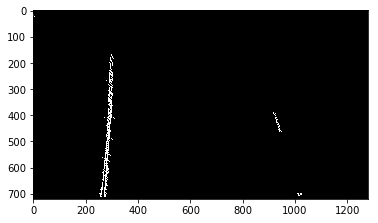

In [75]:
final_result = np.zeros_like(h)
final_result[(y==1)&(color==1)] = 1
src = np.float32([(590,450),(720,450),(250,700),(1050,700)])
offsetx = 280    # x dim offset for dst points
offsety = 0      # y dim offset for dst points
img_size = [final_result.shape[1],final_result.shape[0]]
dst = np.float32([
    [offsetx, offsety], [img_size[0] - offsetx, offsety],
    [offsetx, img_size[1] - offsety],
    [img_size[0] - offsetx, img_size[1] - offsety]
])
M = cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(final_result,M,final_result.shape[::-1],flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='gray')

In [74]:
def detect_LaneLine(img):
    histogram = np.sum(img[img.shape[0]/2:,:],axis=0)
    out_img = np.dstack((img,img,img))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    
    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100 # Set the width of the windows +/- margin
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_hight = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)